In [142]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import json
import matplotlib
import matplotlib.font_manager
import matplotlib.pyplot as plt

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import seaborn as sns
from compose import CompositionAgent

matplotlib.use("Agg")
sns.set(style="white", font="Arial")
colors = sns.color_palette("Paired", n_colors=12).as_hex()


In [143]:
name = "dacgpi"  # sfgpi, msf, dac, dacgpi
time = "2023-02-14-15-25-44/"
model = "model40/"
savefig = False
img_save_path = "/home/yliu2/Documents/thesis/paper/IROS2023_multitaskRL/img/"

path = f"/home/yliu2/catkin_ws/src/TransferLearning/rl/log/{name}/raisimGymTorch.env.bin.pointmass2d/"
exp_path = path + time
model_path = exp_path + model
cfg_path = exp_path + "cfg"

with open(cfg_path) as json_file:
    cfg = json.load(json_file)

cfg["env_cfg"]["record"] = False
cfg["env_cfg"]["render"] = False
cfg["env_cfg"]["save_model"] = False
agent = CompositionAgent(cfg)
agent.load_torch_model(model_path)


In [144]:
cfg["agent_cfg"]


{'alpha': 0.2,
 'alpha_lr': 0.0003,
 'entropy_tuning': False,
 'gamma': 0.99,
 'grad_clip': None,
 'importance_sampling': True,
 'is_clip_max': 1,
 'lr': 0.0019458801306749777,
 'name': 'dacgpi',
 'policy_lr': 0.004682264197273393,
 'policy_net_kwargs': {'layernorm': False, 'sizes': [16, 16]},
 'reward_scale': 1.0,
 'tau': 0.005,
 'td_target_update_interval': 2,
 'updates_per_step': 3,
 'value_net_kwargs': {'activation': 'selu',
  'droprate': 0.01,
  'layernorm': False,
  'sizes': [32, 32]}}

### Analysis

In [145]:
n_s = 100


In [146]:
def add_3d_plot(ax, d0, d1, fn, name, zm, s=0.4):
    df = pd.DataFrame(np.concatenate([d0, d1, fn], 1), columns=[*name])
    df = df.sort_values(by=name[2])

    x = df[name[0]].to_numpy()
    y = df[name[1]].to_numpy()
    z = df[name[2]].to_numpy()

    color = cm.rainbow(np.linspace(0, 1, df[name[2]].to_numpy().shape[0]))
    ax.scatter(x, y, z, s=s, color=color)
    ax.set_zlim(zm[0], zm[1])

    ax.set_title(name[2])
    ax.set_xlabel(name[0])
    ax.set_ylabel(name[1])
    ax.set_zlabel(name[2])

    ax.yaxis.set_major_locator(LinearLocator(5))
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))


def add_3d_surface_plot(ax, d0, d1, fn, name, zm, n_s, mappable):
    d0 = d0.reshape(n_s, n_s)
    d1 = d1.reshape(n_s, n_s)
    fn = fn.reshape(n_s, n_s)

    surf = ax.plot_surface(
        d0,
        d1,
        fn,
        rstride=1,
        cstride=1,
        linewidth=0,
        antialiased=False,
        cmap=mappable.cmap,
        edgecolor="none",
    )
    ax.set_zlim(zm[0], zm[1])

    ax.set_title(name[2])
    ax.set_xlabel(name[0])
    ax.set_ylabel(name[1])
    ax.set_zlabel(name[2])

    ax.yaxis.set_major_locator(LinearLocator(5))
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    return surf


def add_2d_plot(ax, d0, d1, name, s=0.4, x_label=True, y_label=True):
    df = pd.DataFrame(np.concatenate([d0, d1], 1), columns=[*name])

    df = df.sort_values(by=name[1])
    x = df[name[0]].to_numpy()
    y = df[name[1]].to_numpy()
    color = cm.rainbow(np.linspace(0, 1, df[name[1]].to_numpy().shape[0]))
    ax.scatter(x, y, s=s, color=color)
    if x_label:
        ax.set_xlabel(name[0]) 
    if y_label:
        ax.set_ylabel(name[1])

    ax.yaxis.set_major_locator(LinearLocator(5))
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))


def add_historgram(ax, fn, name):
    df = pd.DataFrame(fn, columns=[*name])
    ax.hist(df, bins=50)
    ax.set_xlabel(name[0])

    ax.yaxis.set_major_locator(LinearLocator(5))
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))


def add_2d_surface_plot(ax, d0, d1, fn, name, n_s, mappable, x_label=True, y_label=True):
    d0 = d0.reshape(n_s, n_s)
    d1 = d1.reshape(n_s, n_s)
    fn = fn.reshape(n_s, n_s)

    ax.imshow(
        fn,
        cmap=mappable.cmap,
        norm=mappable.norm,
        extent=(np.min(d0), np.max(d0), np.min(d1), np.max(d1)),
        interpolation="none",
    )

    ax.set_title(name[2])
    if x_label:
        ax.set_xlabel(name[0]) 
    if y_label:
        ax.set_ylabel(name[1])

    ax.yaxis.set_major_locator(LinearLocator(5))
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))


def detach_ts(inp):
    return inp.cpu().detach().numpy()


In [147]:
env = agent.env
device = agent.device
obs_dim = agent.observation_dim
feature_dim = agent.feature_dim
act_dim = agent.action_dim

w = agent.w
policy = agent.policy
sf = agent.sf


In [148]:
dim = 2  # dim in np.meshgrid
s_x = np.linspace(-25, 25, n_s)
s_y = np.linspace(-25, 25, n_s)
s_z = np.zeros([n_s**dim, 1])
s_rotmat = np.zeros([n_s**dim, 9])
s_vx = np.zeros([n_s**dim, 1])
s_vy = np.zeros([n_s**dim, 1])
s_vz = np.zeros([n_s**dim, 1])
s_ang = np.zeros([n_s**dim, 3])
act_x = np.zeros([n_s**dim, 1])
act_y = np.zeros([n_s**dim, 1])

s_x, s_y = np.meshgrid(s_x, s_y)
s_x = s_x.reshape(-1, 1)
s_y = s_y.reshape(-1, 1)

s_grid = np.concatenate([s_x, s_y, s_z, s_rotmat, s_vx, s_vy, s_vz, s_ang], 1)
s_grid_ts = torch.tensor(s_grid).float().reshape(-1, obs_dim).to(device)
a_grid = np.concatenate([act_x, act_y], 1)
a_grid_ts = torch.tensor(a_grid).float().reshape(-1, act_dim).to(device)


In [149]:
w_x = np.array([1, 0, 0])
w_y = np.array([0, 1, 0])
w_z = np.array([0, 0, 1])
wxy_ts = np.array([1, 1, 0])

wx_ts = torch.tensor(w_x, dtype=torch.float32).to(device)
wy_ts = torch.tensor(w_y, dtype=torch.float32).to(device)
wz_ts = torch.tensor(w_z, dtype=torch.float32).to(device)
wxy_ts = torch.tensor(wxy_ts, dtype=torch.float32).to(device)


In [150]:
def get_q_grid(s, a, i):
    sfs1, sfs2 = sf(s, a)
    sfs_grid = torch.min(sfs1, sfs2)  # [N, H, F]
    sfs_i_grid = sfs_grid[:, i, :]

    q_ix_grid = torch.sum(sfs_i_grid * wx_ts, 1, keepdim=True)
    q_iy_grid = torch.sum(sfs_i_grid * wy_ts, 1, keepdim=True)

    q_ix_grid = detach_ts(q_ix_grid)
    q_iy_grid = detach_ts(q_iy_grid)

    return q_ix_grid, q_iy_grid


q_xx_grid, q_xy_grid = get_q_grid(s_grid_ts, a_grid_ts, i=0)
q_yx_grid, q_yy_grid = get_q_grid(s_grid_ts, a_grid_ts, i=1)
q_zx_grid, q_zy_grid = get_q_grid(s_grid_ts, a_grid_ts, i=2)


In [151]:
q_con = np.concatenate(
    [q_xx_grid, q_xy_grid, q_yx_grid, q_yy_grid, q_zx_grid, q_zy_grid], 1
)
q_max = np.max(q_con, 1)
q_max.shape


(10000,)

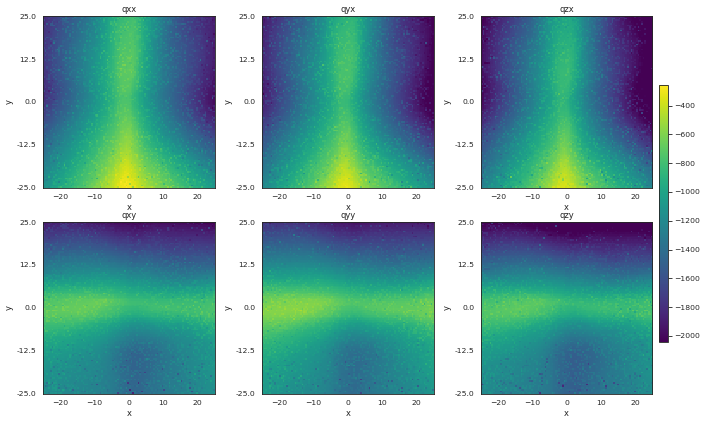

In [152]:
%matplotlib inline
fig = plt.figure(figsize=(16, 10), dpi=50)
f = 2,3

q_con = np.concatenate([q_xx_grid, q_xy_grid, q_yx_grid, q_yy_grid, q_zx_grid, q_zy_grid],1)
avg_q = np.mean(q_con, 1)
mappable = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
mappable.set_array(avg_q.reshape(n_s,n_s))

ax = fig.add_subplot(*f, 1)
add_2d_surface_plot(ax, s_x, s_y, q_xx_grid, ["x","y","qxx"], n_s=n_s, mappable=mappable)
ax = fig.add_subplot(*f, 2)
add_2d_surface_plot(ax, s_x, s_y, q_yx_grid, ["x","y","qyx"], n_s=n_s, mappable=mappable)
ax = fig.add_subplot(*f, 3)
add_2d_surface_plot(ax, s_x, s_y, q_zx_grid, ["x","y","qzx"], n_s=n_s, mappable=mappable)
ax = fig.add_subplot(*f, 4)
add_2d_surface_plot(ax, s_x, s_y, q_xy_grid, ["x","y","qxy"], n_s=n_s, mappable=mappable)
ax = fig.add_subplot(*f, 5)
add_2d_surface_plot(ax, s_x, s_y, q_yy_grid, ["x","y","qyy"], n_s=n_s, mappable=mappable)
ax = fig.add_subplot(*f, 6)
add_2d_surface_plot(ax, s_x, s_y, q_zy_grid, ["x","y","qzy"], n_s=n_s, mappable=mappable)

cax=ax.inset_axes([1.04, 0.3, 0.05, 1.5])
plt.colorbar(mappable, shrink=0.6, cax=cax)

plt.show()

In [153]:
def get_acts(s_grid_ts, i):
    a_dist, _, a_mean = agent.policy(s_grid_ts)

    ai_dist_ts = a_dist[:, i]
    ai_mean_ts = a_mean[:, i]

    ai_dist = detach_ts(ai_dist_ts)
    ai_mean = detach_ts(ai_mean_ts)

    aix_dist = ai_dist[:, 0, None]
    aiy_dist = ai_dist[:, 1, None]
    aix_mean = ai_mean[:, 0, None]
    aiy_mean = ai_mean[:, 1, None]

    return aix_dist, aiy_dist, aix_mean, aiy_mean


axx_dist, axy_dist, axx_mean, axy_mean = get_acts(s_grid_ts, 0)
ayx_dist, ayy_dist, ayx_mean, ayy_mean = get_acts(s_grid_ts, 1)
azx_dist, azy_dist, azx_mean, azy_mean = get_acts(s_grid_ts, 2)


In [154]:
def get_q(s_grid_ts, i):
    _, _, a_mean = agent.policy(s_grid_ts)
    ai_mean_ts = a_mean[:, i]

    sfs1, sfs2 = sf(s_grid_ts, ai_mean_ts)
    sfs_i = torch.min(sfs1, sfs2)  # [N, H, F]

    sf_i = sfs_i[:, i, :]  # [N,F]
    q_ix = torch.sum(sf_i * wx_ts, 1, keepdim=True)
    q_iy = torch.sum(sf_i * wy_ts, 1, keepdim=True)

    q_ix = detach_ts(q_ix)
    q_iy = detach_ts(q_iy)
    return q_ix, q_iy


q_xx, q_xy = get_q(s_grid_ts, 0)
q_yx, q_yy = get_q(s_grid_ts, 1)
q_zx, q_zy = get_q(s_grid_ts, 2)


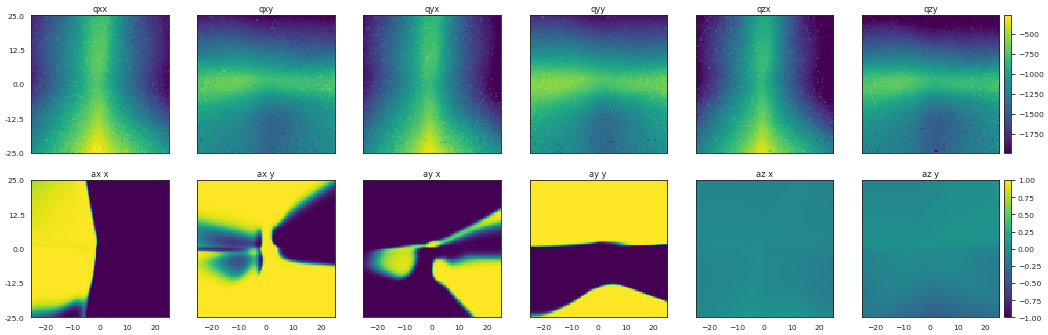

In [155]:
%matplotlib inline
fig = plt.figure(figsize=(25, 8), dpi=50)
f = 2,6
i=1

q_con = np.concatenate([q_xx_grid, q_xy_grid, q_yx_grid, q_yy_grid, q_zx_grid, q_zy_grid],1)
avg_q = np.mean(q_con, 1)
mappable = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
mappable.set_array(avg_q.reshape(n_s,n_s))

ax0 = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax0, s_x, s_y, q_xx, ["x","y","qxx"], n_s=n_s, mappable=mappable, x_label=False, y_label=False)
ax1 = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax1, s_x, s_y, q_xy, ["x","y","qxy"], n_s=n_s, mappable=mappable, x_label=False, y_label=False)
ax2 = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax2, s_x, s_y, q_yx, ["x","y","qyx"], n_s=n_s, mappable=mappable, x_label=False, y_label=False)
ax3 = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax3, s_x, s_y, q_yy, ["x","y","qyy"], n_s=n_s, mappable=mappable, x_label=False, y_label=False)
ax4 = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax4, s_x, s_y, q_zx, ["x","y","qzx"], n_s=n_s, mappable=mappable, x_label=False, y_label=False)
ax5 = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax5, s_x, s_y, q_zy, ["x","y","qzy"], n_s=n_s, mappable=mappable, x_label=False, y_label=False)

[ax.set_xticklabels([]) for ax in [ax0, ax1, ax2, ax3, ax4, ax5]]
[ax.set_yticklabels([]) for ax in [ax1, ax2, ax3, ax4, ax5]]

cax=ax5.inset_axes([1.04, 0.0, 0.05, 1.0])
plt.colorbar(mappable, shrink=0.6, cax=cax)


a_range= (-1,1)
a_con = np.concatenate([axx_mean, axy_mean, ayx_mean, ayy_mean, azx_mean, azy_mean],1)
avg_a = np.mean(a_con, 1)
mappable = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
mappable.set_array(avg_q.reshape(n_s,n_s))
mappable.set_clim(a_range) 

ax6 = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax6, s_x, s_y, axx_mean, ["x","y","ax x"], n_s=n_s, mappable=mappable, x_label=False, y_label=False)
ax7 = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax7, s_x, s_y, axy_mean, ["x","y","ax y"], n_s=n_s, mappable=mappable, x_label=False, y_label=False)
ax8 = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax8, s_x, s_y, ayx_mean, ["x","y","ay x"], n_s=n_s, mappable=mappable, x_label=False, y_label=False)
ax9 = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax9, s_x, s_y, ayy_mean, ["x","y","ay y"], n_s=n_s, mappable=mappable, x_label=False, y_label=False)
ax10 = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax10, s_x, s_y, azx_mean, ["x","y","az x"], n_s=n_s, mappable=mappable, x_label=False, y_label=False)
ax11 = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax11, s_x, s_y, azy_mean, ["x","y","az y"], n_s=n_s, mappable=mappable, x_label=False, y_label=False)

[ax.set_yticklabels([]) for ax in [ax7, ax8,ax9, ax10, ax11]]

cax=ax11.inset_axes([1.04, 0.0, 0.05, 1.0])
plt.colorbar(mappable, shrink=0.6, cax=cax)

plt.show()

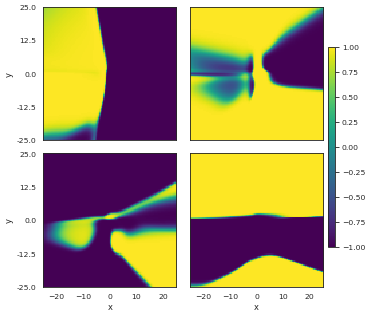

In [156]:
%matplotlib inline
fig = plt.figure(figsize=(8, 8), dpi=50)
f = 2,2
i=1

a_range= (-1,1)
a_con = np.concatenate([axx_mean, axy_mean, ayx_mean, ayy_mean, azx_mean, azy_mean],1)
avg_a = np.mean(a_con, 1)
mappable = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
mappable.set_array(avg_q.reshape(n_s,n_s))
mappable.set_clim(a_range) 

ax6 = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax6, s_x, s_y, axx_mean, ["x","y",""], n_s=n_s, mappable=mappable, x_label=False, y_label=True)
ax7 = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax7, s_x, s_y, axy_mean, ["x","y",""], n_s=n_s, mappable=mappable, x_label=False, y_label=False)
ax8 = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax8, s_x, s_y, ayx_mean, ["x","y",""], n_s=n_s, mappable=mappable, x_label=True, y_label=True)
ax9 = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax9, s_x, s_y, ayy_mean, ["x","y",""], n_s=n_s, mappable=mappable, x_label=True, y_label=False)

[ax.set_xticklabels([]) for ax in [ax6,ax7]]
[ax.set_yticklabels([]) for ax in [ax7, ax9]]

cax=ax9.inset_axes([1.04, 0.3, 0.05, 1.5])
plt.colorbar(mappable, shrink=0.6, cax=cax)


plt.subplots_adjust(left=0.1,
                    right=.8, 
                    bottom=0.1, 
                    top=0.8, 
                    wspace=0.1, 
                    hspace=0.1)

if savefig:
    fig = plt.gcf()
    fig.savefig(img_save_path+"primitives.svg", format="svg")
    fig.savefig(img_save_path+"primitives.png", format="png")

plt.show()

here we change the sampled action from sweep actions to actual policy actions, i.e. a = pi(s)
and identify the corresponding q value and policy action distribtion
for example, 
- top left: we use sf x to evaluate q value of policy x. we can see that q value is the highest when both x and vx are close to 0
- bot left: policy x action mean given state, x and vx. the strategy is to apply positive action when vx<0 (red)

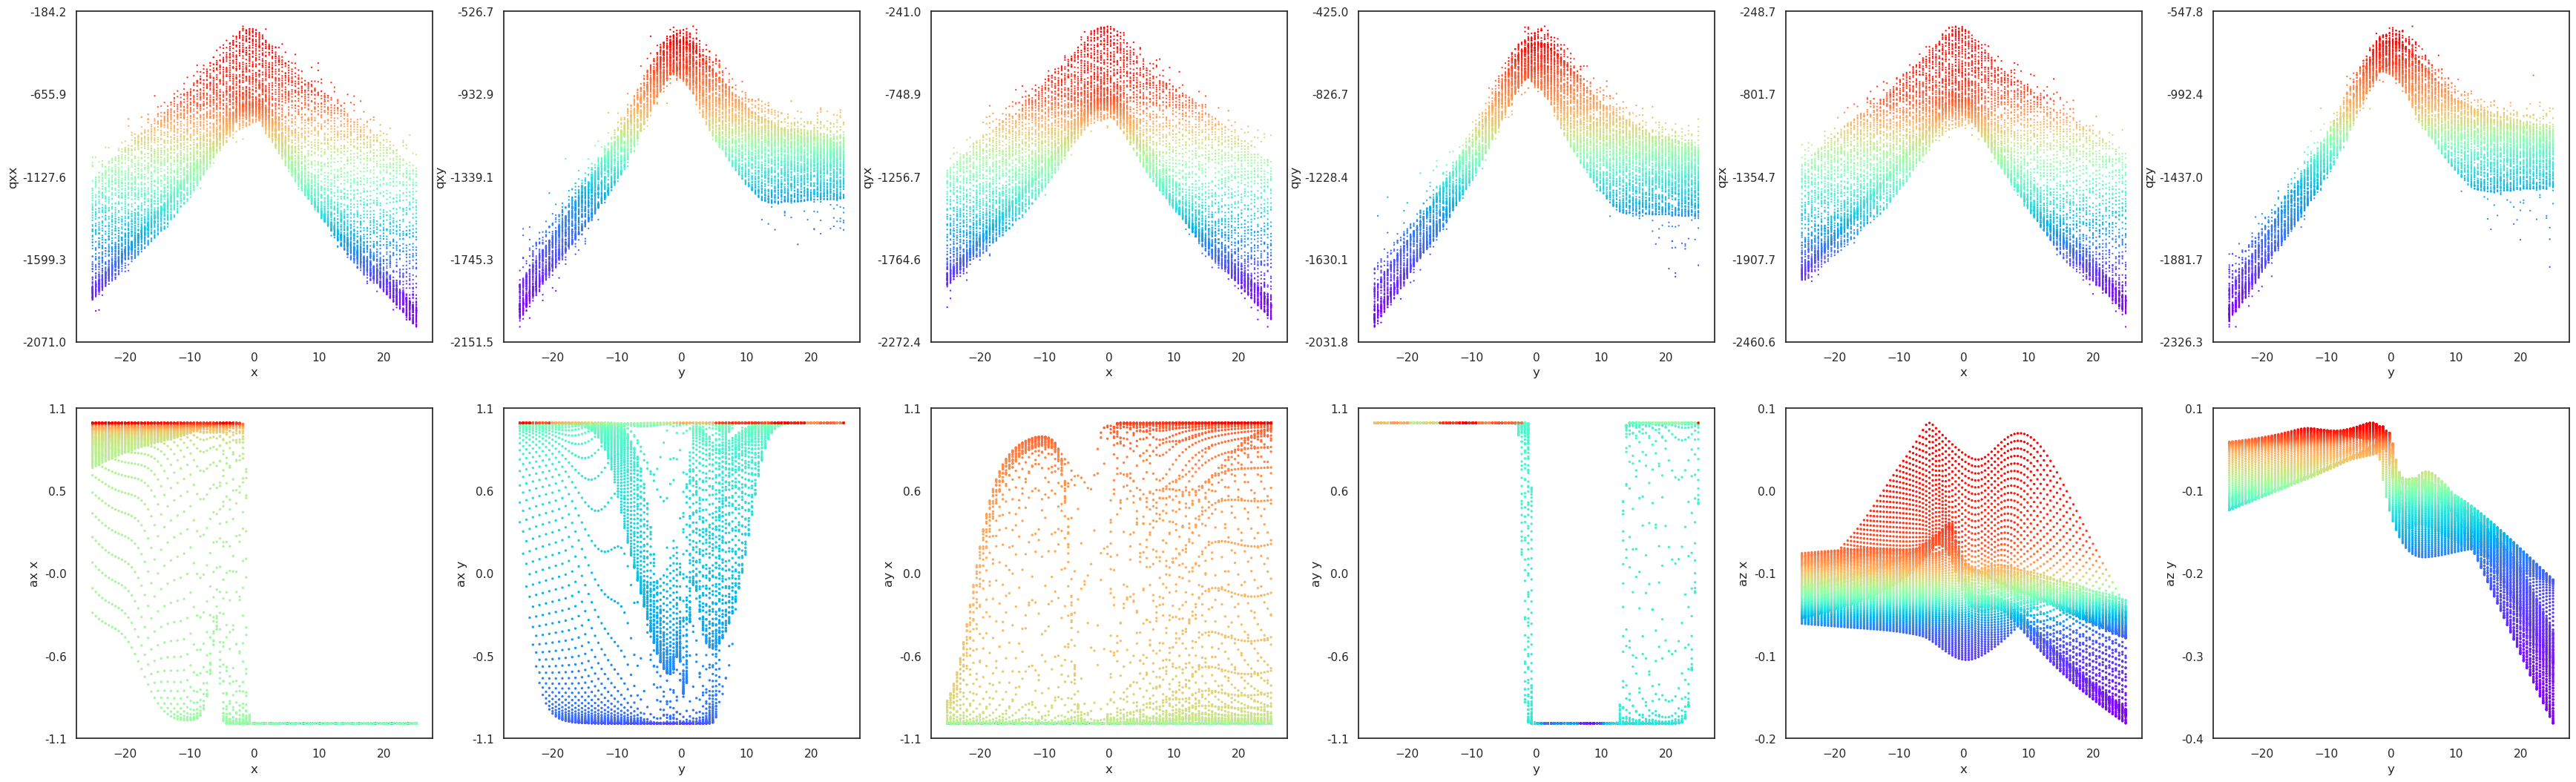

In [157]:
%matplotlib inline
fig = plt.figure(figsize=(21, 14), dpi=100)
f = 2,6
i=1

ax = fig.add_subplot(*f, i); i+=1
add_2d_plot(ax, s_x, q_xx, ["x", "qxx"])
ax = fig.add_subplot(*f, i); i+=1
add_2d_plot(ax, s_y, q_xy, ["y", "qxy"])
ax = fig.add_subplot(*f, i); i+=1
add_2d_plot(ax, s_x, q_yx, ["x", "qyx"])
ax = fig.add_subplot(*f, i); i+=1
add_2d_plot(ax, s_y, q_yy, ["y", "qyy"])
ax = fig.add_subplot(*f, i); i+=1
add_2d_plot(ax, s_x, q_zx, ["x", "qzx"])
ax = fig.add_subplot(*f, i); i+=1
add_2d_plot(ax, s_y, q_zy, ["y", "qzy"])

s=2.0
ax = fig.add_subplot(*f, i); i+=1
add_2d_plot(ax, s_x, axx_mean, ["x", "ax x"], s=s)
ax = fig.add_subplot(*f, i); i+=1
add_2d_plot(ax, s_y, axy_mean, ["y","ax y"], s=s)
ax = fig.add_subplot(*f, i); i+=1
add_2d_plot(ax, s_x, ayx_mean, ["x", "ay x"], s=s)
ax = fig.add_subplot(*f, i); i+=1
add_2d_plot(ax, s_y, ayy_mean, ["y","ay y"], s=s)
ax = fig.add_subplot(*f, i); i+=1
add_2d_plot(ax, s_x, azx_mean, ["x", "az x"], s=s)
ax = fig.add_subplot(*f, i); i+=1
add_2d_plot(ax, s_y, azy_mean, ["y","az y"], s=s)


plt.subplots_adjust(left=0.1,
                    right=1.7, 
                    bottom=0.1, 
                    top=0.8, 
                    wspace=0.2, 
                    hspace=0.2)

plt.show()

In [158]:
x_lim_a = [-4, 0]
x_lim_b = [0, 4]

slice_a = (s_x > x_lim_a[0]) & (s_x < x_lim_a[1])
a_slice_a = axx_dist[slice_a][:, None]

slice_b = (s_x > x_lim_b[0]) & (s_x < x_lim_b[1])
a_slice_b = axx_dist[slice_b][:, None]


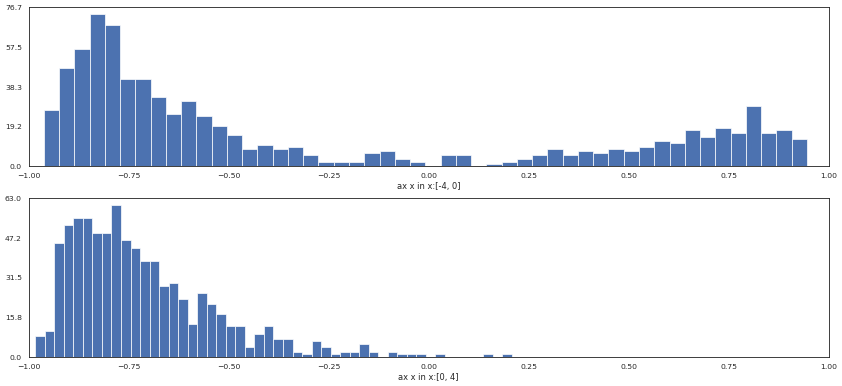

In [159]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10), dpi=50)
f = 2,1

ax = fig.add_subplot(*f, 1)
ax.set_xlim([-1,1])
add_historgram(ax, a_slice_a, [f"ax x in x:{x_lim_a}"])
ax = fig.add_subplot(*f, 2)
ax.set_xlim([-1,1])
add_historgram(ax, a_slice_b, [f"ax x in x:{x_lim_b}"])

plt.subplots_adjust(left=0.1,
                    right=1.7, 
                    bottom=0.1, 
                    top=0.8, 
                    wspace=0.2, 
                    hspace=0.2)

plt.show()

in a certain state (L: x[0,3], R: x[-3,0]. vx~0)
- top row: q value varies across different action
- borrom row: action distribution of the policy

# value composition

In [160]:
w_x = np.array([1, 0, 0])
w_y = np.array([0, 1, 0])
w_xy = np.array([1, 1, 0])
w_task = np.array([0, 15, 0])


In [161]:
def get_q(s_grid_ts, w, mean_or_dist="dist"):
    wx_ts = torch.tensor(w_x, dtype=torch.float32).to(device)
    wy_ts = torch.tensor(w_y, dtype=torch.float32).to(device)
    w_ts = torch.tensor(w, dtype=torch.float32).to(device)

    # primitive action, sf, and q
    a_dist, _, a_mean = agent.policy(s_grid_ts)

    if mean_or_dist == "mean":
        ax_ts = a_mean[:, 0]
        ay_ts = a_mean[:, 1]
    else:
        ax_ts = a_dist[:, 0]
        ay_ts = a_dist[:, 1]

    sfs1, sfs2 = sf(s_grid_ts, ax_ts)
    sfs_x = torch.min(sfs1, sfs2)  # [N, H, F]
    sfs1, sfs2 = sf(s_grid_ts, ay_ts)
    sfs_y = torch.min(sfs1, sfs2)  # [N, H, F]

    sf_x = sfs_x[:, 0, :]  # [N,F]
    sf_y = sfs_y[:, 1, :]  # [N,F]

    # xy task composite q-value by primitives: gpi, sfv, msf
    q_xx = torch.sum(sf_x * wx_ts, 1, keepdim=True)
    q_xy = torch.sum(sf_x * wy_ts, 1, keepdim=True)
    q_yx = torch.sum(sf_y * wx_ts, 1, keepdim=True)
    q_yy = torch.sum(sf_y * wy_ts, 1, keepdim=True)

    q_x_w = torch.sum(sf_x * w_ts, 1, keepdim=True)
    q_y_w = torch.sum(sf_y * w_ts, 1, keepdim=True)
    q_gpi_w = torch.max(torch.concat([q_x_w, q_y_w], 1), 1, keepdim=True)[0]  # gpi
    q_sfv_w = (q_x_w + q_y_w) / 2  # sfv
    q_msf_w = w[0] * q_xx + w[1] * q_yy  # msf

    q_x_w = detach_ts(q_x_w)
    q_y_w = detach_ts(q_y_w)
    q_gpi_w = detach_ts(q_gpi_w)
    q_sfv_w = detach_ts(q_sfv_w)
    q_msf_w = detach_ts(q_msf_w)

    return q_x_w, q_y_w, q_gpi_w, q_sfv_w, q_msf_w


q_x_xy, q_y_xy, q_gpi_xy, q_sfv_xy, q_msf_xy = get_q(s_grid_ts, w_xy, "dist")
q_x_task, q_y_task, q_gpi_task, q_sfv_task, q_msf_task = get_q(
    s_grid_ts, w_task, "dist"
)


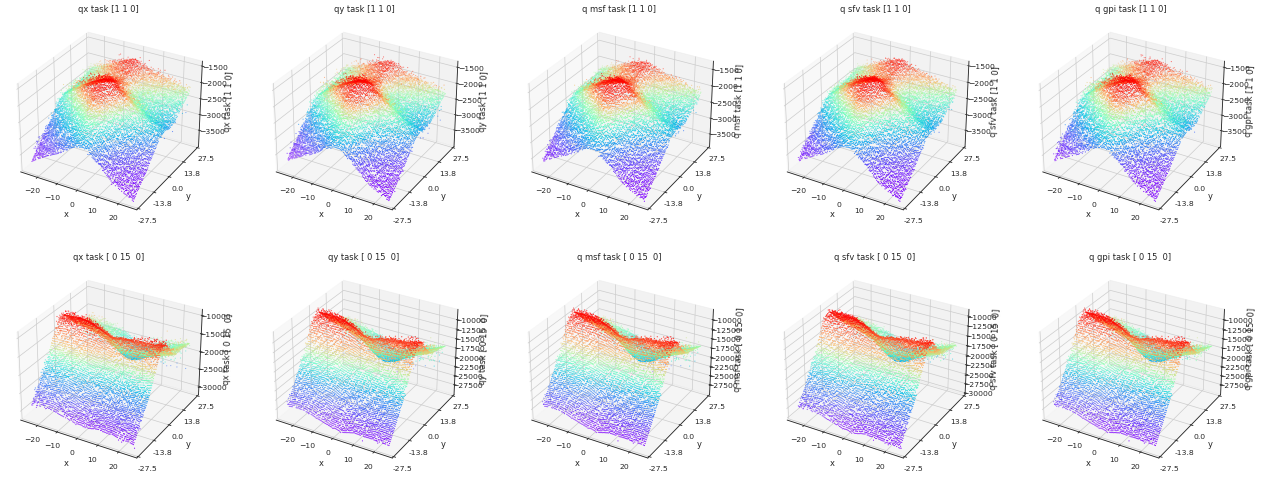

In [162]:
%matplotlib inline
fig = plt.figure(figsize=(13, 13), dpi=50)
f = 2,5

q_x_xy_range=[np.min(q_x_xy),np.max(q_x_xy)]
q_y_xy_range=[np.min(q_y_xy),np.max(q_y_xy)]
q_msf_xy_range=[np.min(q_msf_xy),np.max(q_msf_xy)]
q_sfv_xy_range=[np.min(q_sfv_xy),np.max(q_sfv_xy)]
q_gpi_xy_range=[np.min(q_gpi_xy),np.max(q_gpi_xy)]

q_x_task_range=[np.min(q_x_task),np.max(q_x_task)]
q_y_task_range=[np.min(q_y_task),np.max(q_y_task)]
q_msf_task_range=[np.min(q_msf_task),np.max(q_msf_task)]
q_sfv_task_range=[np.min(q_sfv_task),np.max(q_sfv_task)]
q_gpi_task_range=[np.min(q_gpi_task),np.max(q_gpi_task)]

i=1
ax = fig.add_subplot(*f, i, projection='3d'); i+=1
add_3d_plot(ax, s_x, s_y, q_x_xy, ["x","y",f"qx task {w_xy}"], zm=q_x_xy_range)
ax = fig.add_subplot(*f, i, projection='3d'); i+=1
add_3d_plot(ax, s_x, s_y, q_y_xy, ["x","y",f"qy task {w_xy}"], zm=q_y_xy_range)
ax = fig.add_subplot(*f, i, projection='3d'); i+=1
add_3d_plot(ax, s_x, s_y, q_msf_xy, ["x","y",f"q msf task {w_xy}"], zm=q_msf_xy_range)
ax = fig.add_subplot(*f, i, projection='3d'); i+=1
add_3d_plot(ax, s_x, s_y, q_sfv_xy, ["x","y",f"q sfv task {w_xy}"], zm=q_sfv_xy_range)
ax = fig.add_subplot(*f, i, projection='3d'); i+=1
add_3d_plot(ax, s_x, s_y, q_gpi_xy, ["x","y",f"q gpi task {w_xy}"], zm=q_gpi_xy_range)

ax = fig.add_subplot(*f, i, projection='3d'); i+=1
add_3d_plot(ax, s_x, s_y, q_x_task, ["x","y",f"qx task {w_task}"], zm=q_x_task_range)
ax = fig.add_subplot(*f, i, projection='3d'); i+=1
add_3d_plot(ax, s_x, s_y, q_y_task, ["x","y",f"qy task {w_task}"], zm=q_y_task_range)
ax = fig.add_subplot(*f, i, projection='3d'); i+=1
add_3d_plot(ax, s_x, s_y, q_msf_task, ["x","y",f"q msf task {w_task}"], zm=q_msf_task_range)
ax = fig.add_subplot(*f, i, projection='3d'); i+=1
add_3d_plot(ax, s_x, s_y, q_sfv_task, ["x","y",f"q sfv task {w_task}"], zm=q_sfv_task_range)
ax = fig.add_subplot(*f, i, projection='3d'); i+=1
add_3d_plot(ax, s_x, s_y, q_gpi_task, ["x","y",f"q gpi task {w_task}"], zm=q_gpi_task_range)

plt.subplots_adjust(left=0.1,
                    right=2.0, 
                    bottom=0.1, 
                    top=0.8, 
                    wspace=0.2, 
                    hspace=0.2)

plt.show()

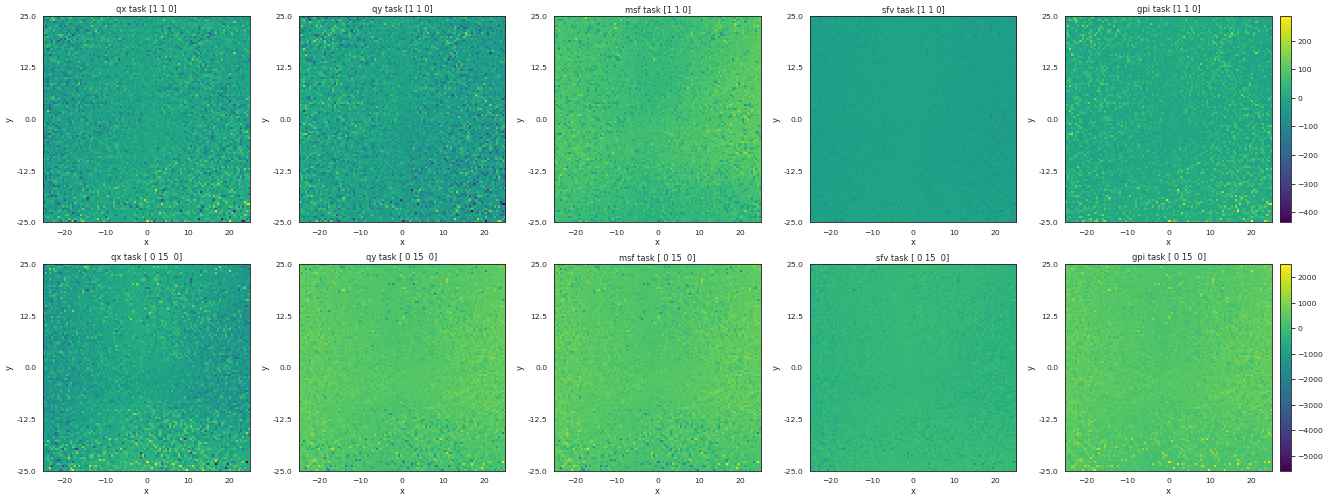

In [163]:
%matplotlib inline
fig = plt.figure(figsize=(13, 13), dpi=50)
f = 2,5
i=1

q_con = np.concatenate([q_x_xy, q_y_xy, q_msf_xy, q_sfv_xy, q_gpi_xy],1)
avg_q = np.mean(q_con, 1).reshape(-1,1)
adv_con = q_con-avg_q
adv_mean = np.mean(adv_con, 1)

mappable = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
mappable.set_array(adv_mean.reshape(n_s,n_s))

ax = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax, s_x, s_y, adv_con[:,0], ["x","y",f"qx task {w_xy}"], n_s=n_s, mappable=mappable )
ax = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax, s_x, s_y, adv_con[:,1], ["x","y",f"qy task {w_xy}"], n_s=n_s, mappable=mappable )
ax = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax, s_x, s_y, adv_con[:,2], ["x","y",f"msf task {w_xy}"], n_s=n_s, mappable=mappable )
ax = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax, s_x, s_y, adv_con[:,3], ["x","y",f"sfv task {w_xy}"], n_s=n_s, mappable=mappable )
ax = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax, s_x, s_y, adv_con[:,4], ["x","y",f"gpi task {w_xy}"], n_s=n_s, mappable=mappable )
cax=ax.inset_axes([1.04, 0.0, 0.05, 1.0])
plt.colorbar(mappable, shrink=0.6, cax=cax)

q_con = np.concatenate([q_x_task, q_y_task, q_msf_task, q_sfv_task, q_gpi_task],1)
avg_q = np.mean(q_con, 1).reshape(-1,1)
adv_con = q_con-avg_q
adv_mean = np.mean(adv_con, 1)

mappable = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
mappable.set_array(adv_mean.reshape(n_s,n_s))

ax = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax, s_x, s_y, adv_con[:,0], ["x","y",f"qx task {w_task}"], n_s=n_s, mappable=mappable )
ax = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax, s_x, s_y, adv_con[:,1], ["x","y",f"qy task {w_task}"], n_s=n_s, mappable=mappable )
ax = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax, s_x, s_y, adv_con[:,2], ["x","y",f"msf task {w_task}"], n_s=n_s, mappable=mappable )
ax = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax, s_x, s_y, adv_con[:,3], ["x","y",f"sfv task {w_task}"], n_s=n_s, mappable=mappable )
ax = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax, s_x, s_y, adv_con[:,4], ["x","y",f"gpi task {w_task}"], n_s=n_s, mappable=mappable )

cax=ax.inset_axes([1.04, 0.0, 0.05, 1.0])
plt.colorbar(mappable, shrink=0.6, cax=cax)

plt.subplots_adjust(left=0.1,
                    right=2.0, 
                    bottom=0.1, 
                    top=0.8, 
                    wspace=0.2, 
                    hspace=0.2)

plt.show()

In [164]:
# average q value in task
print(f"{q_x_task.mean()=}")
print(f"{q_y_task.mean()=}")
print(f"{q_msf_task.mean()=}")
print(f"{q_sfv_task.mean()=}")
print(f"{q_gpi_task.mean()=}")


q_x_task.mean()=-18559.191
q_y_task.mean()=-17337.29
q_msf_task.mean()=-17337.29
q_sfv_task.mean()=-17948.242
q_gpi_task.mean()=-17298.758


# policy composition

In [165]:
torch.cuda.empty_cache()  # free cuda memory


In [166]:
w = (1, 1, 0)
mode = "explore"
x_lim_a = [0, 20]

agent.prev_impact = torch.zeros(s_grid_ts.shape[0], agent.n_heads, agent.action_dim).to(
    agent.device
)


In [167]:
def get_primitives(s_grid_ts, i):
    # primitive
    a_dist, _, a_mean = agent.policy(s_grid_ts)

    ai_dist_ts = a_dist[:, i]
    ai_mean_ts = a_mean[:, i]

    ai_dist = detach_ts(ai_dist_ts)
    ai_mean = detach_ts(ai_mean_ts)

    aix_dist = ai_dist[:, 0, None]
    aiy_dist = ai_dist[:, 1, None]

    aix_mean = ai_mean[:, 0, None]
    aiy_mean = ai_mean[:, 1, None]

    return aix_dist, aiy_dist, aix_mean, aiy_mean


axx_dist, axy_dxst, axx_mean, axy_mean = get_primitives(s_grid_ts, 0)
ayx_dist, ayy_dxst, ayx_mean, ayy_mean = get_primitives(s_grid_ts, 1)
azx_dist, azy_dxst, azx_mean, azy_mean = get_primitives(s_grid_ts, 2)


In [168]:
def get_composed_acts(s_grid_ts, w, method):
    w_ts = torch.tensor(w)
    w_ts = torch.tile(w_ts, (s_grid_ts.shape[0], 1)).float().to(device)

    if method == "msf":
        f = agent.msf
    elif method == "sfgpi":
        f = agent.sfgpi
    elif method == "dac":
        f = agent.dac
    elif method == "dacgpi":
        f = agent.dacgpi

    a_f_dist = f(s_grid_ts, w_ts, mode="explore")  # [N, H, A]
    a_f_mean = f(s_grid_ts, w_ts, mode="exploit")  # [N, H, A]
    a_f_x_dist = a_f_dist[:, 0, None]
    a_f_x_mean = a_f_mean[:, 0, None]
    a_f_x_dist = detach_ts(a_f_x_dist)
    a_f_x_mean = detach_ts(a_f_x_mean)

    return a_f_x_dist, a_f_x_mean


a_msf_x_dist, a_msf_x_mean = get_composed_acts(s_grid_ts, w, "msf")
a_gpi_x_dist, a_gpi_x_mean = get_composed_acts(s_grid_ts, w, "sfgpi")
a_dac_x_dist, a_dac_x_mean = get_composed_acts(s_grid_ts, w, "dac")
a_dacgpi_x_dist, a_dacgpi_x_mean = get_composed_acts(s_grid_ts, w, "dacgpi")


In [169]:
slice_a = (s_x > x_lim_a[0]) & (s_x < x_lim_a[1])

if mode == "explore":
    axx_slice = axx_dist[slice_a][:, None]
    ayx_slice = ayx_dist[slice_a][:, None]
    azx_slice = azx_dist[slice_a][:, None]
    amsf_slice = a_msf_x_dist[slice_a][:, None]
    agpi_slice = a_gpi_x_dist[slice_a][:, None]
    adac_slice = a_dac_x_dist[slice_a][:, None]
    adacgpi_slice = a_dacgpi_x_dist[slice_a][:, None]
else:
    axx_slice = axx_mean[slice_a][:, None]
    ayx_slice = ayx_mean[slice_a][:, None]
    azx_slice = azx_mean[slice_a][:, None]
    amsf_slice = a_msf_x_mean[slice_a][:, None]
    agpi_slice = a_gpi_x_mean[slice_a][:, None]
    adac_slice = a_dac_x_mean[slice_a][:, None]
    adacgpi_slice = a_dacgpi_x_mean[slice_a][:, None]


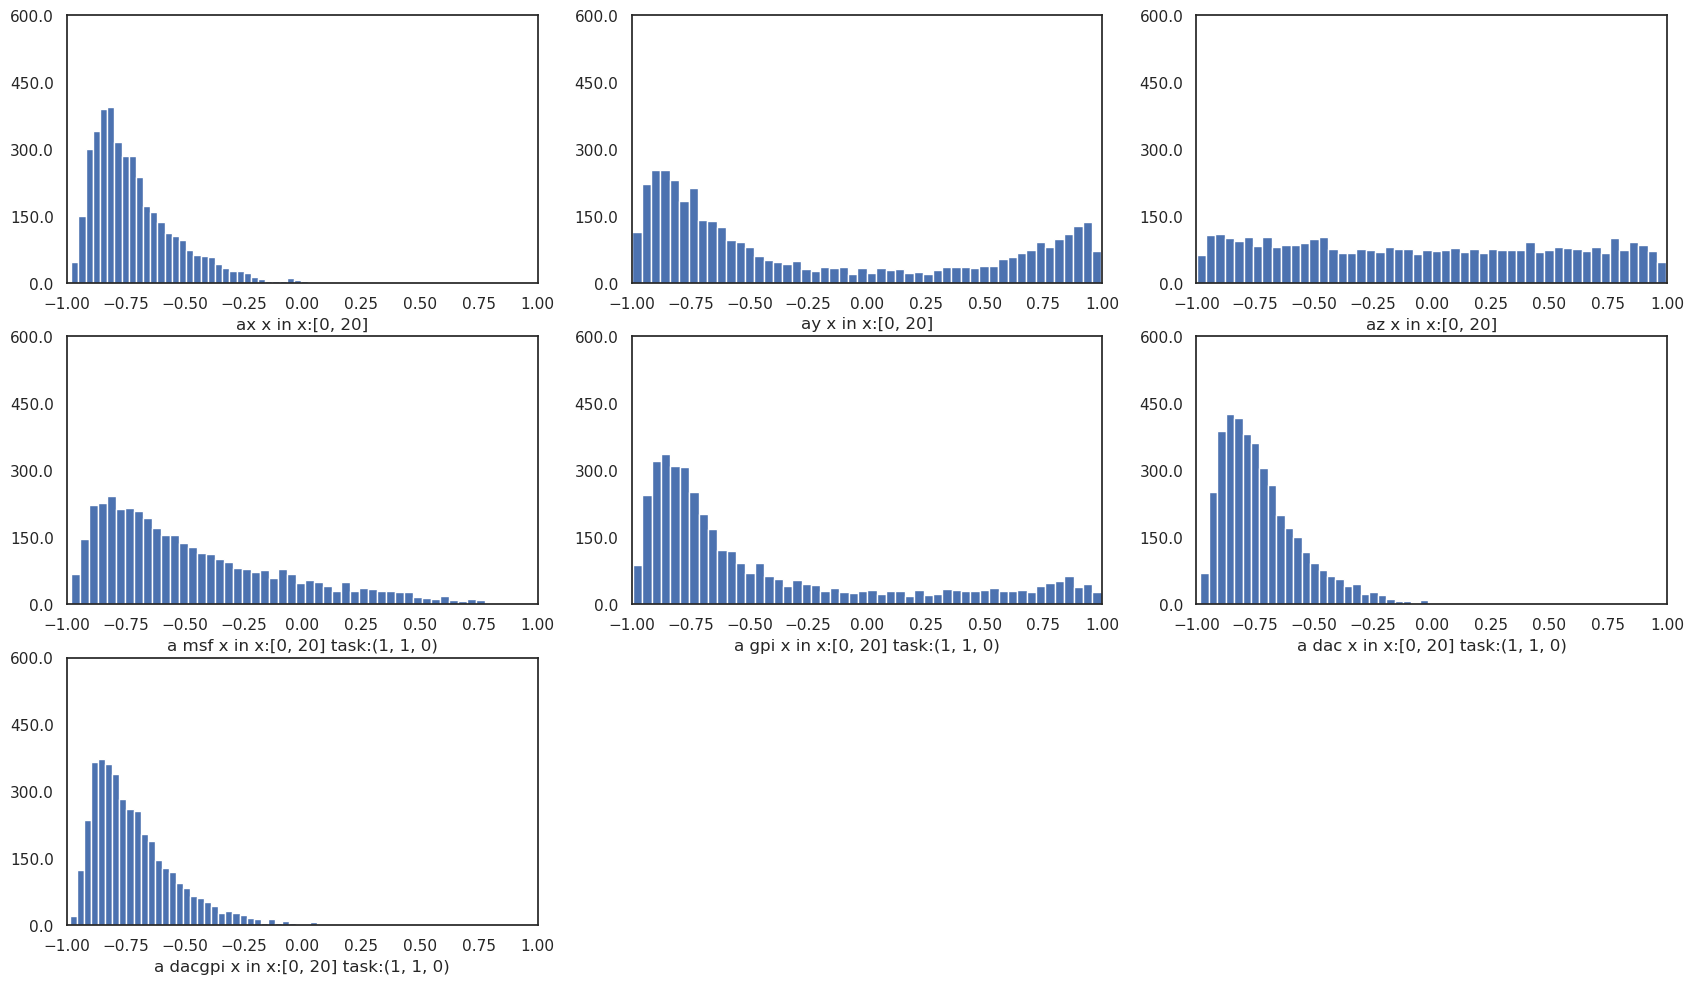

In [170]:
%matplotlib inline
fig = plt.figure(figsize=(10, 13), dpi=100)
f = 3,3
i=1

ax = fig.add_subplot(*f, i); i+=1
ax.set_xlim([-1,1])
ax.set_ylim([0,600])
add_historgram(ax, axx_slice, [f"ax x in x:{x_lim_a}"])
ax = fig.add_subplot(*f, i); i+=1
ax.set_xlim([-1,1])
ax.set_ylim([0,600])
add_historgram(ax, ayx_slice, [f"ay x in x:{x_lim_a}"])
ax = fig.add_subplot(*f, i); i+=1
ax.set_xlim([-1,1])
ax.set_ylim([0,600])
add_historgram(ax, azx_slice, [f"az x in x:{x_lim_a}"])
ax = fig.add_subplot(*f, i); i+=1
ax.set_xlim([-1,1])
ax.set_ylim([0,600])
add_historgram(ax, amsf_slice, [f"a msf x in x:{x_lim_a} task:{w}"])
ax = fig.add_subplot(*f, i); i+=1
ax.set_xlim([-1,1])
ax.set_ylim([0,600])
add_historgram(ax, agpi_slice, [f"a gpi x in x:{x_lim_a} task:{w}"])
ax = fig.add_subplot(*f, i); i+=1
ax.set_xlim([-1,1])
ax.set_ylim([0,600])
add_historgram(ax, adac_slice, [f"a dac x in x:{x_lim_a} task:{w}"])
ax = fig.add_subplot(*f, i); i+=1
ax.set_xlim([-1,1])
ax.set_ylim([0,600])
add_historgram(ax, adacgpi_slice, [f"a dacgpi x in x:{x_lim_a} task:{w}"])

plt.subplots_adjust(left=0.1,
                    right=1.7, 
                    bottom=0.1, 
                    top=0.8, 
                    wspace=0.2, 
                    hspace=0.2)

plt.show()

# impact and kappa

In [171]:
import functorch
from rl.rl_torch.common.util import pile_sa_pairs

Epsilon = 1e-6


def calc_impact(s, policy_or_random, n_value_particles):
    if policy_or_random == "policy":
        a, _, _ = agent.policy(s)
        num = agent.n_heads
    else:
        a = (
            torch.distributions.uniform.Uniform(-1, 1)
            .sample((s.shape[0], n_value_particles, agent.action_dim))
            .to(agent.device)
        )
        num = n_value_particles

    s, a = pile_sa_pairs(s, a)

    agent.sf = agent.sf.eval()
    func = lambda s, a: torch.min(*agent.sf(s, a))  # [NHa, Hsf, F]
    j = functorch.vmap(functorch.jacrev(func, argnums=1))(s, a)  # [NHa,Hsf,F,A]
    # [N,Ha,Hsf,F,A]
    j = j.view(-1, num, agent.n_heads, agent.feature_dim, agent.action_dim)
    impact = j.mean((1, 2)).abs()  # [N,F,A]<-[N,Ha,Hsf,F,A]
    agent.sf = agent.sf.train()

    return impact


def calc_adv(s, a):
    sf = torch.min(*agent.sf(s, a))  # [NHa, Hsf, F]
    adv = sf - sf.mean(1, keepdim=True)  # [NHa, Hsf, F]
    return adv


def calc_impact_by_adv(s):
    a, _, _ = agent.policy(s)

    s, a = pile_sa_pairs(s, a)

    agent.sf = agent.sf.eval()
    func = lambda s, a: calc_adv(s, a)  # [NHa, Hsf, F]
    j = functorch.vmap(functorch.jacrev(func, argnums=1))(s, a)  # [NHa,Hsf,F,A]
    j = j.view(-1, agent.n_heads, agent.n_heads, agent.feature_dim, agent.action_dim)
    impact = j.mean((1, 2)).abs()  # [N,F,A]<-[N,Ha,Hsf,F,A]
    agent.sf = agent.sf.train()

    return impact


def scale_gating(gating):
    return torch.softmax(gating / gating.shape[1], 1)


In [172]:
w_ts = torch.tensor(w)
w_ts = torch.tile(w_ts, (s_grid_ts.shape[0], 1)).float().to(device)

impact = calc_impact(s_grid_ts, "policy", 20)
# impact = calc_impact_by_adv(s_grid_ts)
impact = scale_gating(impact)

acts, _, _ = agent.policy(s_grid_ts)
curr_sf = agent.calc_curr_sf(s_grid_ts, acts)  # [N,Ha,Hsf,F]<--[N,S],[N,Ha,A]
advantage = agent.calc_advantage(curr_sf)  # [N,Hsf,F] <-- [N, Ha, Hsf, F]
filtered_adv = torch.relu(advantage)  # filter out kappa below average
kappa = torch.einsum(
    "ijk,ik,ikl->ijl", filtered_adv, w_ts, impact
)  # [N,H,A]<--[N,Hsf,F], [N,F], [N,F,A]
scaled_kappa = scale_gating(kappa)

acts = detach_ts(acts)
curr_sf = detach_ts(curr_sf)
impact = detach_ts(impact)
advantage = detach_ts(advantage)
filtered_adv = detach_ts(filtered_adv)
kappa = detach_ts(kappa)
scaled_kappa = detach_ts(scaled_kappa)


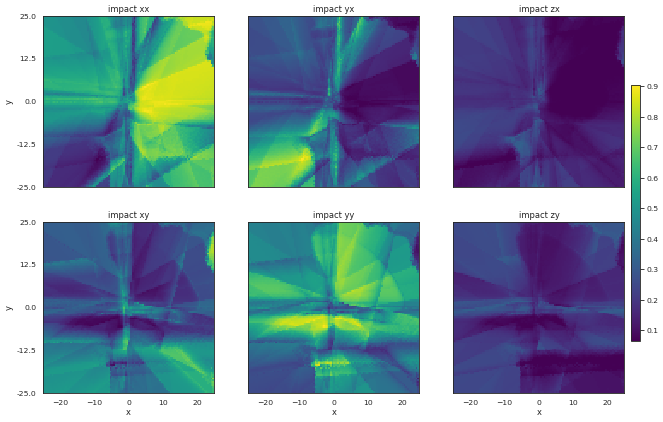

In [173]:
%matplotlib inline
fig = plt.figure(figsize=(15, 10), dpi=50)
f = 2,3

impact_xx = impact[:,0,0,None]
impact_yx = impact[:,1,0,None]
impact_zx = impact[:,2,0,None]
impact_xy = impact[:,0,1,None]
impact_yy = impact[:,1,1,None]
impact_zy = impact[:,2,1,None]

impact_con = np.concatenate([impact_xx, impact_yx, impact_zx, impact_xy, impact_yy, impact_zy],1)
avg_impact = np.mean(impact_con, 1)
mappable = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
mappable.set_array(avg_impact.reshape(n_s,n_s))

i=1; remove_xtick=[]; remove_ytick=[]
ax = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax, s_x, s_y, impact_xx, ["x","y","impact xx"], n_s=n_s, mappable=mappable, x_label=False)
remove_xtick.append(ax)
ax = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax, s_x, s_y, impact_yx, ["x","y","impact yx"], n_s=n_s, mappable=mappable, x_label=False, y_label=False)
remove_xtick.append(ax); remove_ytick.append(ax)
ax = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax, s_x, s_y, impact_zx, ["x","y","impact zx"], n_s=n_s, mappable=mappable, x_label=False, y_label=False)
remove_xtick.append(ax); remove_ytick.append(ax)

ax = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax, s_x, s_y, impact_xy, ["x","y","impact xy"], n_s=n_s, mappable=mappable)
ax = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax, s_x, s_y, impact_yy, ["x","y","impact yy"], n_s=n_s, mappable=mappable, y_label=False)
remove_ytick.append(ax)
ax = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax, s_x, s_y, impact_zy, ["x","y","impact zy"], n_s=n_s, mappable=mappable, y_label=False)
remove_ytick.append(ax)

cax=ax.inset_axes([1.04, 0.3, 0.05, 1.5])
plt.colorbar(mappable, shrink=0.6, cax=cax)

[ax.set_xticklabels([]) for ax in remove_xtick]
[ax.set_yticklabels([]) for ax in remove_ytick]

if savefig:
    fig = plt.gcf()
    fig.savefig(img_save_path+"impact.svg", format="svg")
    fig.savefig(img_save_path+"impact.png", format="png")

plt.show()

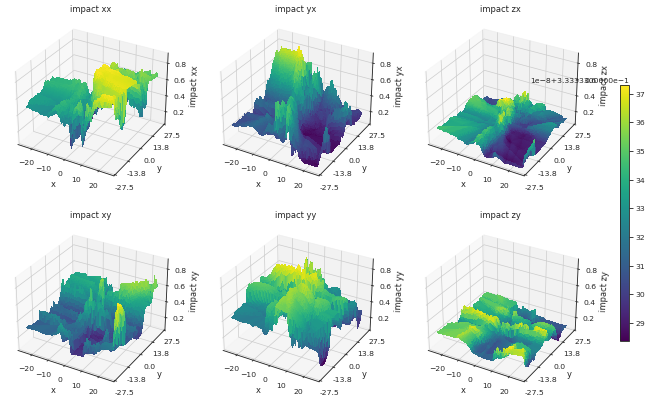

In [174]:
%matplotlib inline
fig = plt.figure(figsize=(15, 10), dpi=50)
f = 2,3

impact_xx = impact[:,0,0,None]
impact_yx = impact[:,1,0,None]
impact_zx = impact[:,2,0,None]
impact_xy = impact[:,0,1,None]
impact_yy = impact[:,1,1,None]
impact_zy = impact[:,2,1,None]

impact_con = np.concatenate([impact_xx, impact_yx, impact_zx, impact_xy, impact_yy, impact_zy],1)
avg_impact = np.mean(impact_con, 1)
mappable = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
mappable.set_array(avg_impact.reshape(n_s,n_s))

impact_xx_range=[np.min(impact_xx),np.max(impact_xx)]
impact_yx_range=[np.min(impact_yx),np.max(impact_yx)]
impact_zx_range=[np.min(impact_zx),np.max(impact_zx)]
impact_xy_range=[np.min(impact_xy),np.max(impact_xy)]
impact_yy_range=[np.min(impact_yy),np.max(impact_yy)]
impact_zy_range=[np.min(impact_zy),np.max(impact_zy)]


i=1
ax = fig.add_subplot(*f, i, projection='3d'); i+=1
add_3d_surface_plot(ax, s_x, s_y, impact_xx, ["x","y","impact xx"], n_s=n_s, mappable=mappable, zm=impact_xx_range)
ax = fig.add_subplot(*f, i, projection='3d'); i+=1
add_3d_surface_plot(ax, s_x, s_y, impact_yx, ["x","y","impact yx"], n_s=n_s, mappable=mappable, zm=impact_xx_range)
ax = fig.add_subplot(*f, i, projection='3d'); i+=1
add_3d_surface_plot(ax, s_x, s_y, impact_zx, ["x","y","impact zx"], n_s=n_s, mappable=mappable, zm=impact_xx_range)
ax = fig.add_subplot(*f, i, projection='3d'); i+=1
add_3d_surface_plot(ax, s_x, s_y, impact_xy, ["x","y","impact xy"], n_s=n_s, mappable=mappable, zm=impact_xx_range)
ax = fig.add_subplot(*f, i, projection='3d'); i+=1
add_3d_surface_plot(ax, s_x, s_y, impact_yy, ["x","y","impact yy"], n_s=n_s, mappable=mappable, zm=impact_xx_range)
ax = fig.add_subplot(*f, i, projection='3d'); i+=1
add_3d_surface_plot(ax, s_x, s_y, impact_zy, ["x","y","impact zy"], n_s=n_s, mappable=mappable, zm=impact_xx_range)

cax=ax.inset_axes([1.2, 0.3, 0.05, 1.5])
plt.colorbar(mappable, shrink=0.6, cax=cax)


plt.show()

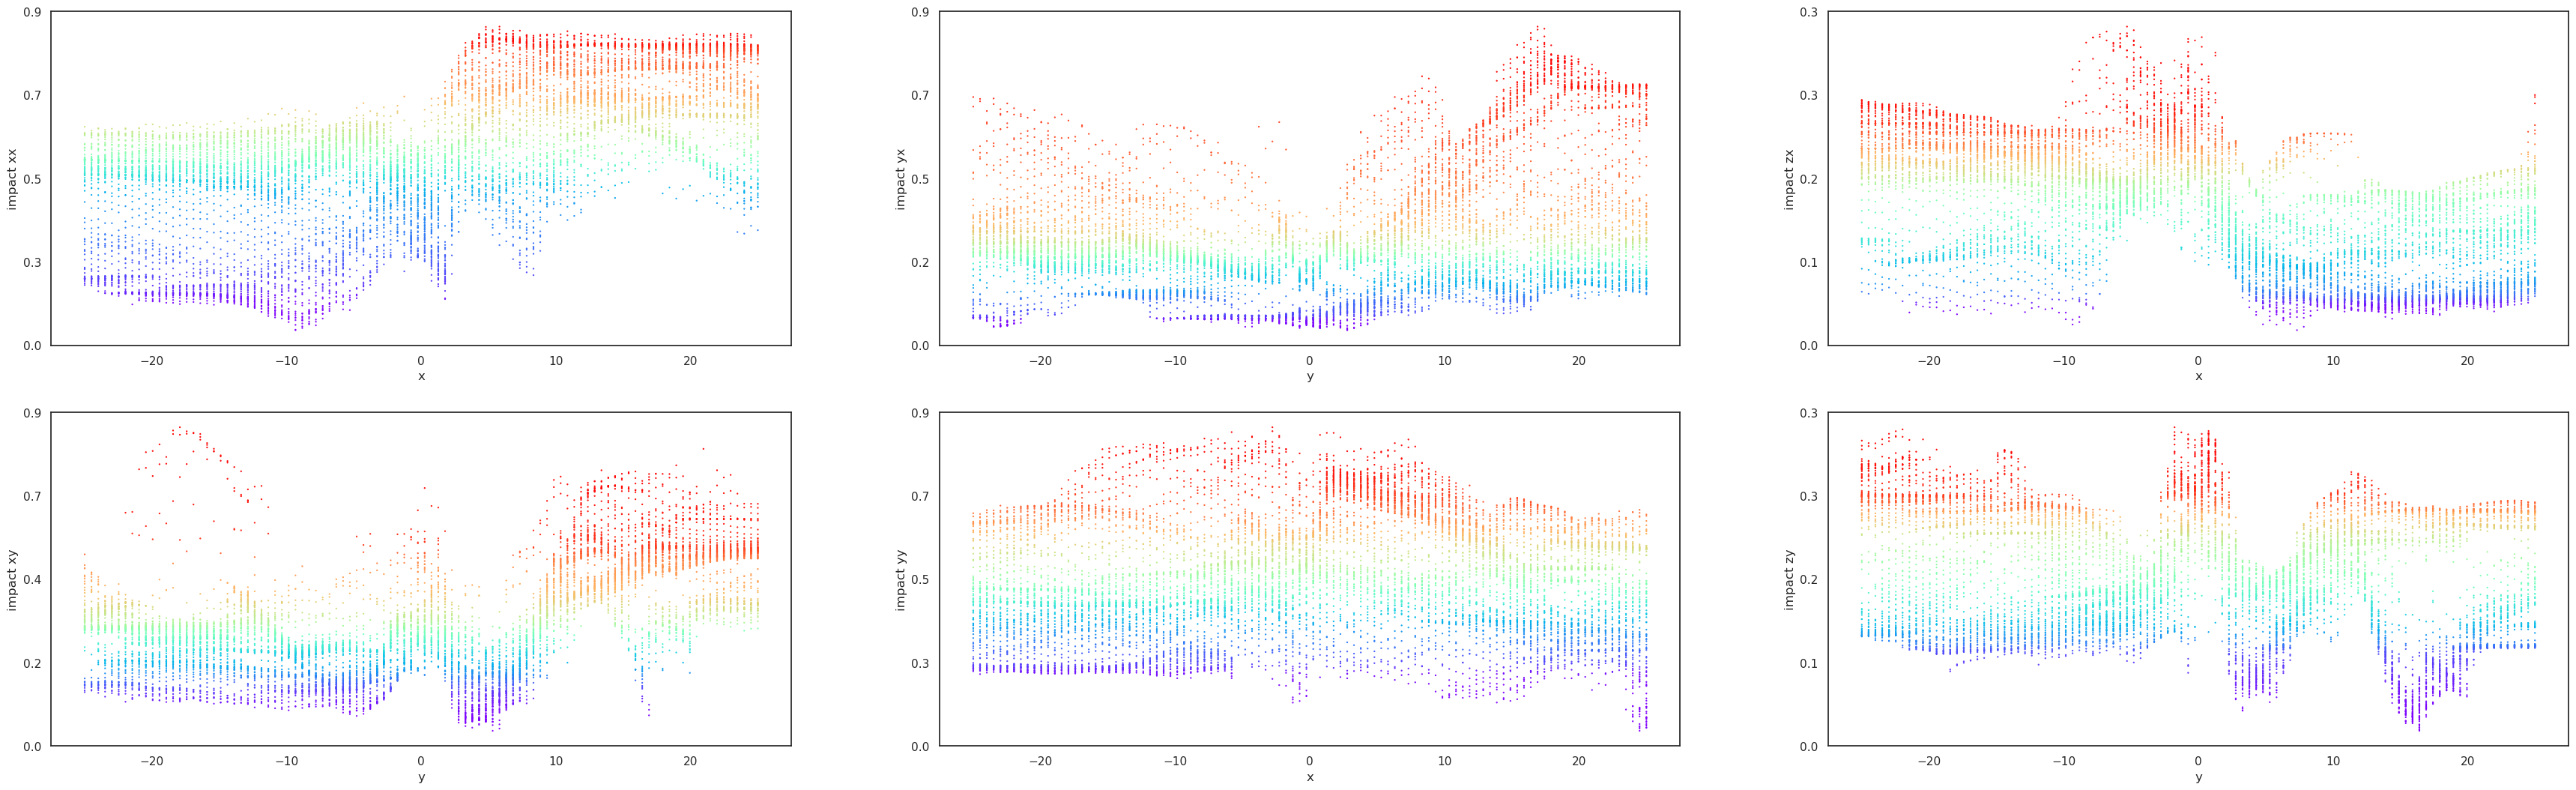

In [175]:
%matplotlib inline
fig = plt.figure(figsize=(21, 14), dpi=100)
f = 2,3
i=1

impact_xx = impact[:,0,0,None]
impact_yx = impact[:,1,0,None]
impact_zx = impact[:,2,0,None]
impact_xy = impact[:,0,1,None]
impact_yy = impact[:,1,1,None]
impact_zy = impact[:,2,1,None]


ax = fig.add_subplot(*f, i); i+=1
add_2d_plot(ax, s_x, impact_xx, ["x", "impact xx"])
ax = fig.add_subplot(*f, i); i+=1
add_2d_plot(ax, s_y, impact_yx, ["y", "impact yx"])
ax = fig.add_subplot(*f, i); i+=1
add_2d_plot(ax, s_x, impact_zx, ["x", "impact zx"])
ax = fig.add_subplot(*f, i); i+=1
add_2d_plot(ax, s_y, impact_xy, ["y", "impact xy"])
ax = fig.add_subplot(*f, i); i+=1
add_2d_plot(ax, s_x, impact_yy, ["x", "impact yy"])
ax = fig.add_subplot(*f, i); i+=1
add_2d_plot(ax, s_y, impact_zy, ["y", "impact zy"])


plt.subplots_adjust(left=0.1,
                    right=1.7, 
                    bottom=0.1, 
                    top=0.8, 
                    wspace=0.2, 
                    hspace=0.2)

plt.show()

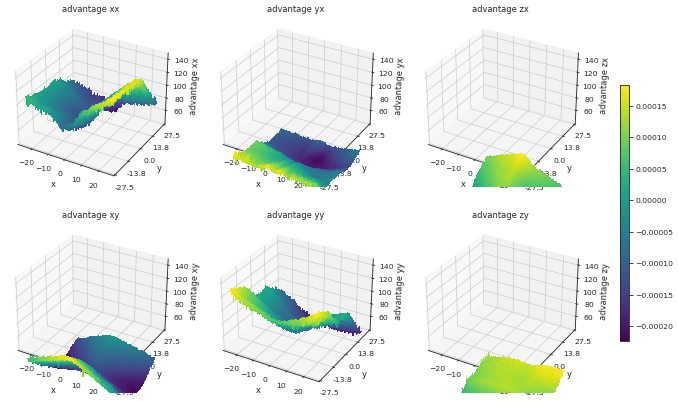

In [176]:
%matplotlib inline
fig = plt.figure(figsize=(15, 10), dpi=50)
f = 2,3

advantage_xx = advantage[:,0,0,None]
advantage_yx = advantage[:,1,0,None]
advantage_zx = advantage[:,2,0,None]
advantage_xy = advantage[:,0,1,None]
advantage_yy = advantage[:,1,1,None]
advantage_zy = advantage[:,2,1,None]

advantage_con = np.concatenate([advantage_xx, advantage_yx, advantage_zx, advantage_xy, advantage_yy, advantage_zy],1)
avg_advantage = np.mean(advantage_con, 1)
mappable = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
mappable.set_array(avg_advantage.reshape(n_s,n_s))

advantage_xx_range=[np.min(advantage_xx),np.max(advantage_xx)]
advantage_yx_range=[np.min(advantage_yx),np.max(advantage_yx)]
advantage_zx_range=[np.min(advantage_zx),np.max(advantage_zx)]
advantage_xy_range=[np.min(advantage_xy),np.max(advantage_xy)]
advantage_yy_range=[np.min(advantage_yy),np.max(advantage_yy)]
advantage_zy_range=[np.min(advantage_zy),np.max(advantage_zy)]

i=1
ax = fig.add_subplot(*f, i, projection='3d'); i+=1
add_3d_surface_plot(ax, s_x, s_y, advantage_xx, ["x","y","advantage xx"], n_s=n_s, mappable=mappable, zm=advantage_xx_range)
ax = fig.add_subplot(*f, i, projection='3d'); i+=1
add_3d_surface_plot(ax, s_x, s_y, advantage_yx, ["x","y","advantage yx"], n_s=n_s, mappable=mappable, zm=advantage_xx_range)
ax = fig.add_subplot(*f, i, projection='3d'); i+=1
add_3d_surface_plot(ax, s_x, s_y, advantage_zx, ["x","y","advantage zx"], n_s=n_s, mappable=mappable, zm=advantage_xx_range)
ax = fig.add_subplot(*f, i, projection='3d'); i+=1
add_3d_surface_plot(ax, s_x, s_y, advantage_xy, ["x","y","advantage xy"], n_s=n_s, mappable=mappable, zm=advantage_xx_range)
ax = fig.add_subplot(*f, i, projection='3d'); i+=1
add_3d_surface_plot(ax, s_x, s_y, advantage_yy, ["x","y","advantage yy"], n_s=n_s, mappable=mappable, zm=advantage_xx_range)
ax = fig.add_subplot(*f, i, projection='3d'); i+=1
add_3d_surface_plot(ax, s_x, s_y, advantage_zy, ["x","y","advantage zy"], n_s=n_s, mappable=mappable, zm=advantage_xx_range)

cax=ax.inset_axes([1.2, 0.3, 0.05, 1.5])
plt.colorbar(mappable, shrink=0.6, cax=cax)


plt.show()

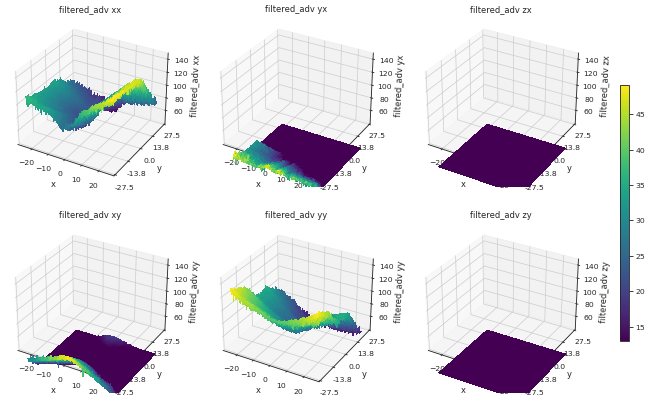

In [177]:
%matplotlib inline
fig = plt.figure(figsize=(15, 10), dpi=50)
f = 2,3

filtered_adv_xx = filtered_adv[:,0,0,None]
filtered_adv_yx = filtered_adv[:,1,0,None]
filtered_adv_zx = filtered_adv[:,2,0,None]
filtered_adv_xy = filtered_adv[:,0,1,None]
filtered_adv_yy = filtered_adv[:,1,1,None]
filtered_adv_zy = filtered_adv[:,2,1,None]

filtered_adv_con = np.concatenate([filtered_adv_xx, filtered_adv_yx, filtered_adv_zx, filtered_adv_xy, filtered_adv_yy, filtered_adv_zy],1)
avg_filtered_adv = np.mean(filtered_adv_con, 1)
mappable = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
mappable.set_array(avg_filtered_adv.reshape(n_s,n_s))

filtered_adv_xx_range=[np.min(filtered_adv_xx),np.max(filtered_adv_xx)]
filtered_adv_yx_range=[np.min(filtered_adv_yx),np.max(filtered_adv_yx)]
filtered_adv_zx_range=[np.min(filtered_adv_zx),np.max(filtered_adv_zx)]
filtered_adv_xy_range=[np.min(filtered_adv_xy),np.max(filtered_adv_xy)]
filtered_adv_yy_range=[np.min(filtered_adv_yy),np.max(filtered_adv_yy)]
filtered_adv_zy_range=[np.min(filtered_adv_zy),np.max(filtered_adv_zy)]

i=1
ax = fig.add_subplot(*f, i, projection='3d'); i+=1
add_3d_surface_plot(ax, s_x, s_y, filtered_adv_xx, ["x","y","filtered_adv xx"], n_s=n_s, mappable=mappable, zm=filtered_adv_xx_range)
ax = fig.add_subplot(*f, i, projection='3d'); i+=1
add_3d_surface_plot(ax, s_x, s_y, filtered_adv_yx, ["x","y","filtered_adv yx"], n_s=n_s, mappable=mappable, zm=filtered_adv_xx_range)
ax = fig.add_subplot(*f, i, projection='3d'); i+=1
add_3d_surface_plot(ax, s_x, s_y, filtered_adv_zx, ["x","y","filtered_adv zx"], n_s=n_s, mappable=mappable, zm=filtered_adv_xx_range)
ax = fig.add_subplot(*f, i, projection='3d'); i+=1
add_3d_surface_plot(ax, s_x, s_y, filtered_adv_xy, ["x","y","filtered_adv xy"], n_s=n_s, mappable=mappable, zm=filtered_adv_xx_range)
ax = fig.add_subplot(*f, i, projection='3d'); i+=1
add_3d_surface_plot(ax, s_x, s_y, filtered_adv_yy, ["x","y","filtered_adv yy"], n_s=n_s, mappable=mappable, zm=filtered_adv_xx_range)
ax = fig.add_subplot(*f, i, projection='3d'); i+=1
add_3d_surface_plot(ax, s_x, s_y, filtered_adv_zy, ["x","y","filtered_adv zy"], n_s=n_s, mappable=mappable, zm=filtered_adv_xx_range)

cax=ax.inset_axes([1.2, 0.3, 0.05, 1.5])
plt.colorbar(mappable, shrink=0.6, cax=cax)


if savefig:
    fig = plt.gcf()
    fig.savefig(img_save_path+"advantage.svg", format="svg")
    fig.savefig(img_save_path+"advantage.png", format="png")

plt.show()

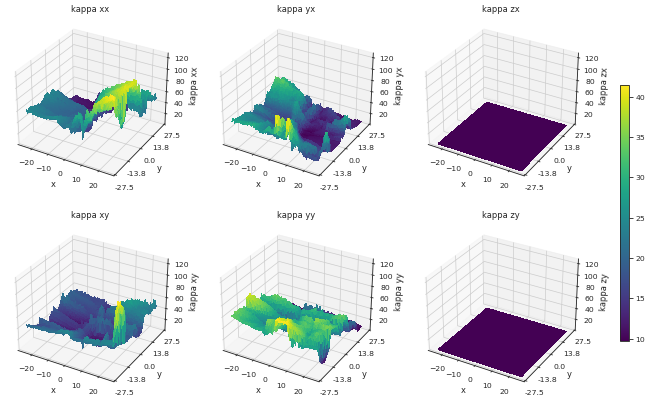

In [178]:
%matplotlib inline
fig = plt.figure(figsize=(15, 10), dpi=50)
f = 2,3

kappa_xx = kappa[:,0,0,None]
kappa_yx = kappa[:,1,0,None]
kappa_zx = kappa[:,2,0,None]
kappa_xy = kappa[:,0,1,None]
kappa_yy = kappa[:,1,1,None]
kappa_zy = kappa[:,2,1,None]

kappa_con = np.concatenate([kappa_xx, kappa_yx, kappa_zx, kappa_xy, kappa_yy, kappa_zy],1)
avg_kappa = np.mean(kappa_con, 1)
mappable = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
mappable.set_array(avg_kappa.reshape(n_s,n_s))

kappa_xx_range=[np.min(kappa_xx),np.max(kappa_xx)]
kappa_yx_range=[np.min(kappa_yx),np.max(kappa_yx)]
kappa_zx_range=[np.min(kappa_zx),np.max(kappa_zx)]
kappa_xy_range=[np.min(kappa_xy),np.max(kappa_xy)]
kappa_yy_range=[np.min(kappa_yy),np.max(kappa_yy)]
kappa_zy_range=[np.min(kappa_zy),np.max(kappa_zy)]

i=1
ax = fig.add_subplot(*f, i, projection='3d'); i+=1
add_3d_surface_plot(ax, s_x, s_y, kappa_xx, ["x","y","kappa xx"], n_s=n_s, mappable=mappable, zm=kappa_xx_range)
ax = fig.add_subplot(*f, i, projection='3d'); i+=1
add_3d_surface_plot(ax, s_x, s_y, kappa_yx, ["x","y","kappa yx"], n_s=n_s, mappable=mappable, zm=kappa_xx_range)
ax = fig.add_subplot(*f, i, projection='3d'); i+=1
add_3d_surface_plot(ax, s_x, s_y, kappa_zx, ["x","y","kappa zx"], n_s=n_s, mappable=mappable, zm=kappa_xx_range)
ax = fig.add_subplot(*f, i, projection='3d'); i+=1
add_3d_surface_plot(ax, s_x, s_y, kappa_xy, ["x","y","kappa xy"], n_s=n_s, mappable=mappable, zm=kappa_xx_range)
ax = fig.add_subplot(*f, i, projection='3d'); i+=1
add_3d_surface_plot(ax, s_x, s_y, kappa_yy, ["x","y","kappa yy"], n_s=n_s, mappable=mappable, zm=kappa_xx_range)
ax = fig.add_subplot(*f, i, projection='3d'); i+=1
add_3d_surface_plot(ax, s_x, s_y, kappa_zy, ["x","y","kappa zy"], n_s=n_s, mappable=mappable, zm=kappa_xx_range)

cax=ax.inset_axes([1.2, 0.3, 0.05, 1.5])
plt.colorbar(mappable, shrink=0.6, cax=cax)


plt.show()

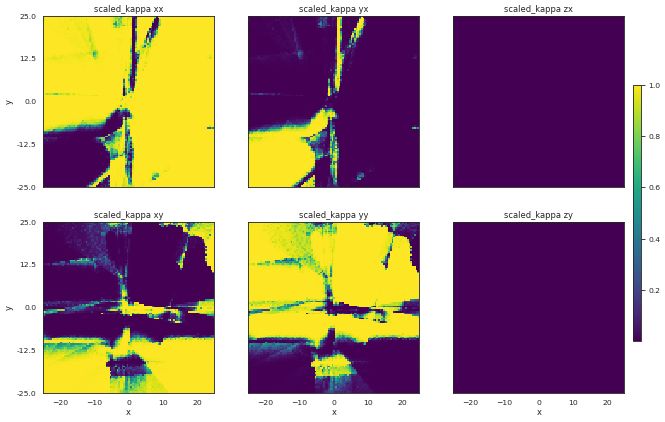

In [179]:
%matplotlib inline

fig = plt.figure(figsize=(15, 10), dpi=50)
f = 2,3

scaled_kappa_xx = scaled_kappa[:,0,0,None]
scaled_kappa_yx = scaled_kappa[:,1,0,None]
scaled_kappa_zx = scaled_kappa[:,2,0,None]
scaled_kappa_xy = scaled_kappa[:,0,1,None]
scaled_kappa_yy = scaled_kappa[:,1,1,None]
scaled_kappa_zy = scaled_kappa[:,2,1,None]

scaled_kappa_con = np.concatenate([scaled_kappa_xx, scaled_kappa_yx, scaled_kappa_zx, scaled_kappa_xy, scaled_kappa_yy, scaled_kappa_zy],1)
avg_scaled_kappa = np.mean(scaled_kappa_con, 1)
mappable = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
mappable.set_array(avg_scaled_kappa.reshape(n_s,n_s))

i=1; remove_xtick=[]; remove_ytick=[]
ax = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax, s_x, s_y, scaled_kappa_xx, ["x","y","scaled_kappa xx"], n_s=n_s, mappable=mappable, x_label=False)
remove_xtick.append(ax)
ax = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax, s_x, s_y, scaled_kappa_yx, ["x","y","scaled_kappa yx"], n_s=n_s, mappable=mappable, x_label=False, y_label=False)
remove_xtick.append(ax); remove_ytick.append(ax)
ax = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax, s_x, s_y, scaled_kappa_zx, ["x","y","scaled_kappa zx"], n_s=n_s, mappable=mappable, x_label=False, y_label=False)
remove_xtick.append(ax); remove_ytick.append(ax)
ax = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax, s_x, s_y, scaled_kappa_xy, ["x","y","scaled_kappa xy"], n_s=n_s, mappable=mappable)
ax = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax, s_x, s_y, scaled_kappa_yy, ["x","y","scaled_kappa yy"], n_s=n_s, mappable=mappable, y_label=False)
remove_ytick.append(ax)
ax = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax, s_x, s_y, scaled_kappa_zy, ["x","y","scaled_kappa zy"], n_s=n_s, mappable=mappable, y_label=False)
remove_ytick.append(ax)

cax=ax.inset_axes([1.05, 0.3, 0.05, 1.5])
plt.colorbar(mappable, shrink=0.6, cax=cax)

[ax.set_xticklabels([]) for ax in remove_xtick]
[ax.set_yticklabels([]) for ax in remove_ytick]

if savefig:
    fig = plt.gcf()
    fig.subplots_adjust(wspace=0.2, hspace=0.2, right=0.9)
    fig.savefig(img_save_path+"kappa.svg", format="svg")
    fig.savefig(img_save_path+"kappa.png", format="png")

plt.show()

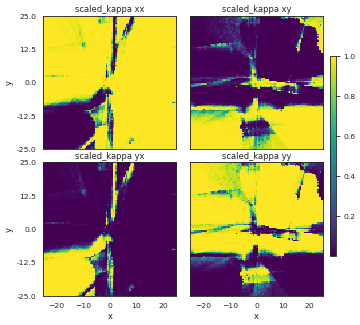

In [184]:
%matplotlib inline

fig = plt.figure(figsize=(8, 8), dpi=50)
f = 2,2

scaled_kappa_xx = scaled_kappa[:,0,0,None]
scaled_kappa_yx = scaled_kappa[:,1,0,None]
scaled_kappa_zx = scaled_kappa[:,2,0,None]
scaled_kappa_xy = scaled_kappa[:,0,1,None]
scaled_kappa_yy = scaled_kappa[:,1,1,None]
scaled_kappa_zy = scaled_kappa[:,2,1,None]

scaled_kappa_con = np.concatenate([scaled_kappa_xx, scaled_kappa_yx, scaled_kappa_zx, scaled_kappa_xy, scaled_kappa_yy, scaled_kappa_zy],1)
avg_scaled_kappa = np.mean(scaled_kappa_con, 1)
mappable = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
mappable.set_array(avg_scaled_kappa.reshape(n_s,n_s))

i=1; remove_xtick=[]; remove_ytick=[]
ax = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax, s_x, s_y, scaled_kappa_xx, ["x","y","scaled_kappa xx"], n_s=n_s, mappable=mappable, x_label=False)
remove_xtick.append(ax)
ax = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax, s_x, s_y, scaled_kappa_xy, ["x","y","scaled_kappa xy"], n_s=n_s, mappable=mappable, x_label=False, y_label=False)
remove_xtick.append(ax); remove_ytick.append(ax)
ax = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax, s_x, s_y, scaled_kappa_yx, ["x","y","scaled_kappa yx"], n_s=n_s, mappable=mappable)
ax = fig.add_subplot(*f, i); i+=1
add_2d_surface_plot(ax, s_x, s_y, scaled_kappa_yy, ["x","y","scaled_kappa yy"], n_s=n_s, mappable=mappable, y_label=False)
remove_ytick.append(ax)

cax=ax.inset_axes([1.05, 0.3, 0.05, 1.5])
plt.colorbar(mappable, shrink=0.6, cax=cax)

[ax.set_xticklabels([]) for ax in remove_xtick]
[ax.set_yticklabels([]) for ax in remove_ytick]


plt.subplots_adjust(left=0.1,
                    right=.8, 
                    bottom=0.1, 
                    top=0.8, 
                    wspace=0.1, 
                    hspace=0.1)
                    
plt.show()